## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing


pd.set_option('display.max_rows', 500)

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("Data/covid19.csv")

In [3]:
df.shape

(232232, 18)

In [4]:
df.head(2)

,Unnamed: 0,index,continent,country,population,day,time,cases_new,cases_active,cases_critical,cases_recovered,cases_1M_pop,cases_total,deaths_new,deaths_1M_pop,deaths_total,tests_1M_pop,tests_total
0,0,0,Asia,Afghanistan,40418964.0,2022-03-17,2022-03-17T20:15:03+00:00,128.0,9698.0,1124.0,159569.0,4377.0,176918,NaN,189.0,7651.0,22496.0,909246.0
1,1,1,Asia,Afghanistan,40416563.0,2022-03-17,2022-03-17T08:00:04+00:00,126.0,9858.0,1124.0,159234.0,4373.0,176743,2.0,189.0,7651.0,22463.0,907896.0


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking + Feature engineering (Aggregation)

In [5]:
# Relevance
df.columns

Index(['Unnamed: 0', 'index', 'continent', 'country', 'population', 'day',
       'time', 'cases_new', 'cases_active', 'cases_critical',
       'cases_recovered', 'cases_1M_pop', 'cases_total', 'deaths_new',
       'deaths_1M_pop', 'deaths_total', 'tests_1M_pop', 'tests_total'],
      dtype='object')

In [6]:
# df['country'].value_counts().head(100)

In [7]:
df_saudi = df[df['country']=='Saudi-Arabia']
print(df_saudi.shape)
df_saudi.head()

(1217, 18)


,Unnamed: 0,index,continent,country,population,day,time,cases_new,cases_active,cases_critical,cases_recovered,cases_1M_pop,cases_total,deaths_new,deaths_1M_pop,deaths_total,tests_1M_pop,tests_total
167363,167363,0,Asia,Saudi-Arabia,35736063.0,2022-03-17,2022-03-17T20:15:03+00:00,97.0,8606.0,223.0,731638.0,20967.0,749268,+1,253.0,9024.0,1156280.0,41320890.0
167364,167364,1,Asia,Saudi-Arabia,35736063.0,2022-03-17,2022-03-17T12:30:03+00:00,127.0,8708.0,229.0,731440.0,20964.0,749171,+2,252.0,9023.0,1155812.0,41304165.0
167365,167365,2,Asia,Saudi-Arabia,35734581.0,2022-03-17,2022-03-17T00:00:04+00:00,127.0,8708.0,229.0,731440.0,20965.0,749171,+2,253.0,9023.0,1155860.0,41304165.0
167366,167366,3,Asia,Saudi-Arabia,35734581.0,2022-03-16,2022-03-16T13:15:04+00:00,129.0,8804.0,256.0,731219.0,20961.0,749044,+1,252.0,9021.0,1155318.0,41284790.0
167367,167367,4,Asia,Saudi-Arabia,35733098.0,2022-03-16,2022-03-16T00:00:03+00:00,129.0,8804.0,256.0,731219.0,20962.0,749044,+1,252.0,9021.0,1155366.0,41284790.0


In [8]:
df_saudi = df_saudi[['time', 'cases_new',
                     'cases_active', 'cases_critical',
                     'cases_recovered', 'cases_total', 
                     'deaths_total']]

In [9]:
df_saudi.head(2)

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
167363,2022-03-17T20:15:03+00:00,97.0,8606.0,223.0,731638.0,749268,9024.0
167364,2022-03-17T12:30:03+00:00,127.0,8708.0,229.0,731440.0,749171,9023.0


In [10]:
# Accurecy types
df_saudi.dtypes

time                object
cases_new          float64
cases_active       float64
cases_critical     float64
cases_recovered    float64
cases_total          int64
deaths_total       float64
dtype: object

In [11]:
# Convert the 'time' column
df_saudi['time'] = pd.to_datetime(df_saudi['time'], errors='coerce')  # 'coerce' will turn any error into NaT (missing value)

In [12]:
df_saudi.head()

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
167363,2022-03-17 20:15:03+00:00,97.0,8606.0,223.0,731638.0,749268,9024.0
167364,2022-03-17 12:30:03+00:00,127.0,8708.0,229.0,731440.0,749171,9023.0
167365,2022-03-17 00:00:04+00:00,127.0,8708.0,229.0,731440.0,749171,9023.0
167366,2022-03-16 13:15:04+00:00,129.0,8804.0,256.0,731219.0,749044,9021.0
167367,2022-03-16 00:00:03+00:00,129.0,8804.0,256.0,731219.0,749044,9021.0


In [13]:
# uniqeness
df_saudi[df_saudi.duplicated()]

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total


In [14]:
df_saudi[df_saudi.duplicated(['time'])]

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total


In [15]:
# Completeness
df_saudi.isnull().sum()

time                0
cases_new          18
cases_active        0
cases_critical      7
cases_recovered     0
cases_total         0
deaths_total        4
dtype: int64

In [16]:
# fix types
df_saudi = df_saudi.sort_values(['time'], ascending=True)
df_saudi.head(10)

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
168579,2020-03-22 12:45:09+00:00,NaN,376.0,NaN,16.0,392,NaN
168578,2020-03-23 13:15:05+00:00,119.0,494.0,NaN,17.0,511,NaN
168577,2020-03-24 12:00:06+00:00,51.0,543.0,NaN,19.0,562,NaN
168576,2020-03-24 12:46:13+00:00,205.0,748.0,NaN,19.0,767,NaN
168575,2020-03-25 12:30:06+00:00,205.0,738.0,NaN,28.0,767,1.0
168574,2020-03-25 12:45:06+00:00,133.0,871.0,NaN,28.0,900,1.0
168573,2020-03-26 12:45:06+00:00,133.0,869.0,NaN,29.0,900,2.0
168572,2020-03-27 12:45:05+00:00,112.0,976.0,6.0,33.0,1012,3.0
168571,2020-03-28 12:45:05+00:00,92.0,1066.0,6.0,35.0,1104,3.0
168570,2020-03-29 12:30:05+00:00,99.0,1162.0,6.0,37.0,1203,4.0


In [17]:
# assume first days were not have a critical cases pr death
df_saudi.cases_critical.fillna(0, inplace=True)
df_saudi.deaths_total.fillna(0, inplace=True)

In [18]:
df_saudi[df_saudi.cases_new.isnull()]

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
168579,2020-03-22 12:45:09+00:00,NaN,376.0,0.0,16.0,392,0.0
168561,2020-04-02 12:45:06+00:00,NaN,1371.0,31.0,328.0,1720,21.0
168518,2020-04-22 12:45:08+00:00,NaN,9882.0,81.0,1640.0,11631,109.0
168473,2020-05-12 12:45:05+00:00,NaN,28022.0,149.0,12737.0,41014,255.0
168470,2020-05-14 13:00:04+00:00,NaN,26935.0,147.0,17622.0,44830,273.0
168462,2020-05-17 12:45:05+00:00,NaN,28048.0,166.0,23666.0,52016,302.0
168430,2020-05-29 12:30:06+00:00,NaN,25191.0,384.0,54553.0,80185,441.0
168427,2020-05-31 12:30:05+00:00,NaN,24021.0,384.0,58883.0,83384,480.0
168423,2020-06-02 13:00:07+00:00,NaN,22311.0,384.0,64306.0,87142,525.0
168398,2020-06-13 12:45:06+00:00,NaN,38020.0,1820.0,81029.0,119942,893.0


In [19]:
# fill as next day
df_saudi.cases_new.bfill(inplace=True)

In [20]:
df_saudi.isnull().sum()

time               0
cases_new          0
cases_active       0
cases_critical     0
cases_recovered    0
cases_total        0
deaths_total       0
dtype: int64

In [21]:
# Accurecy - Outlier
df_saudi.head(2)

,time,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
168579,2020-03-22 12:45:09+00:00,119.0,376.0,0.0,16.0,392,0.0
168578,2020-03-23 13:15:05+00:00,119.0,494.0,0.0,17.0,511,0.0


In [22]:
#check for days or hours or months?
df_saudi.shape

(1217, 7)

In [23]:
df_saudi = df_saudi.set_index('time')
df_saudi_agg_day = df_saudi.resample('D').max()
df_saudi_agg_day.shape

(726, 6)

In [24]:
df_saudi_agg_day.head(2)

,cases_new,cases_active,cases_critical,cases_recovered,cases_total,deaths_total
time,,,,,,
2020-03-22 00:00:00+00:00,119.0,376.0,0.0,16.0,392.0,0.0
2020-03-23 00:00:00+00:00,119.0,494.0,0.0,17.0,511.0,0.0


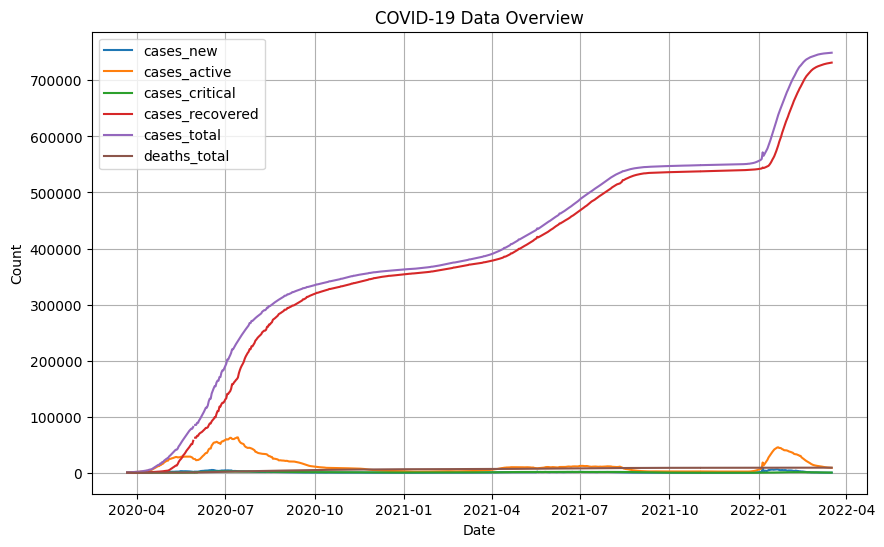

In [25]:
# Plotting all columns as lines
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
for column in df_saudi_agg_day.columns:
    plt.plot(df_saudi_agg_day.index, df_saudi_agg_day[column], label=column)

plt.title('COVID-19 Data Overview')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Optionally add a grid
plt.show()

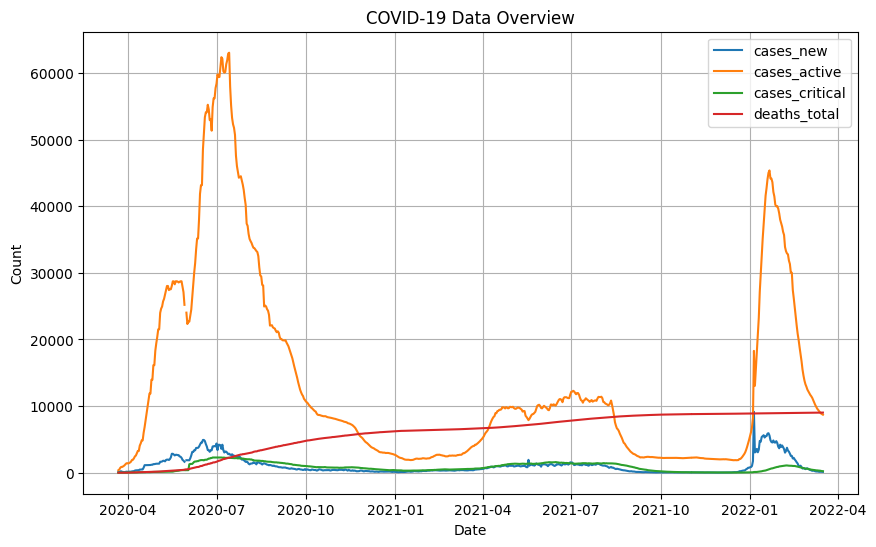

In [26]:
# Plotting all columns as lines
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
for column in [['cases_new', 'cases_active', 'cases_critical', 'deaths_total']]:
    plt.plot(df_saudi_agg_day.index, df_saudi_agg_day[column], label=column)

plt.title('COVID-19 Data Overview')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Optionally add a grid
plt.show()

In [27]:
# there is disconnected values

In [28]:
df_saudi_agg_day.isnull().sum()

cases_new          2
cases_active       2
cases_critical     2
cases_recovered    2
cases_total        2
deaths_total       2
dtype: int64

In [29]:
df_saudi_agg_day.bfill(inplace=True)

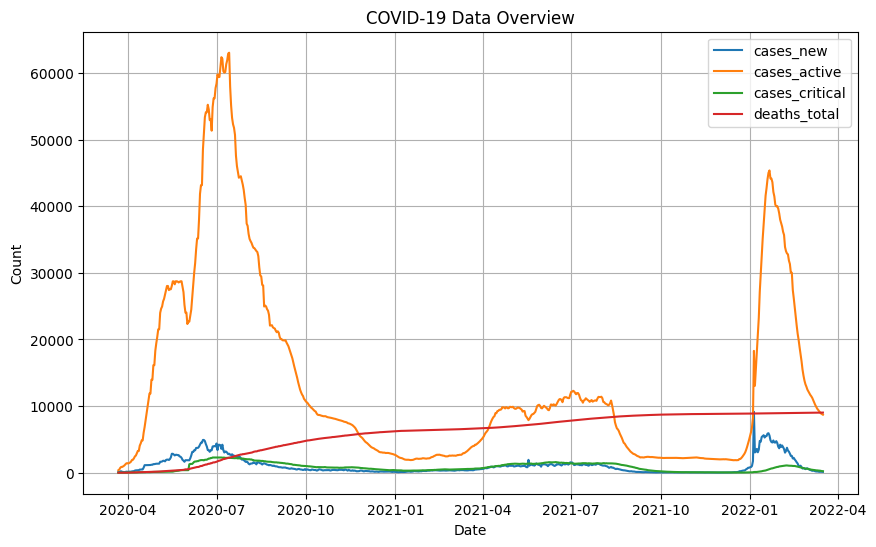

In [30]:
# Plotting all columns as lines
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
for column in [['cases_new', 'cases_active', 'cases_critical', 'deaths_total']]:
    plt.plot(df_saudi_agg_day.index, df_saudi_agg_day[column], label=column)

plt.title('COVID-19 Data Overview')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Optionally add a grid
plt.show()

In [31]:
# Resampling data by month and calculating the mean
df_saudi_agg_month = df_saudi.resample('M').mean()
df_saudi_agg_month.shape

(25, 6)

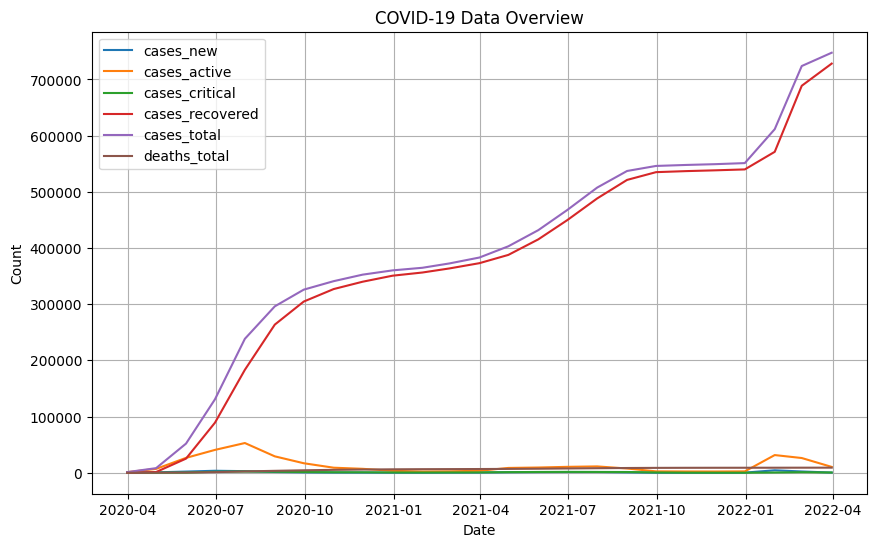

In [32]:
# Plotting all columns as lines
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
for column in df_saudi_agg_month.columns:
    plt.plot(df_saudi_agg_month.index, df_saudi_agg_month[column], label=column)

plt.title('COVID-19 Data Overview')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Optionally add a grid
plt.show()

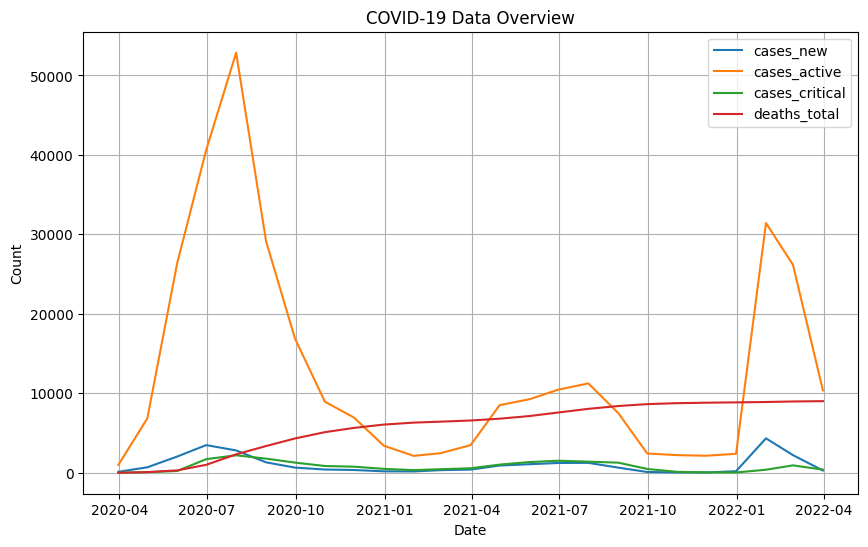

In [33]:
# Plotting all columns as lines
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
for column in [['cases_new', 'cases_active', 'cases_critical', 'deaths_total']]:
    plt.plot(df_saudi_agg_month.index, df_saudi_agg_month[column], label=column)

plt.title('COVID-19 Data Overview')  # Title of the plot
plt.xlabel('Date')  # X-axis label
plt.ylabel('Count')  # Y-axis label
plt.legend()  # Add a legend
plt.grid(True)  # Optionally add a grid
plt.show()

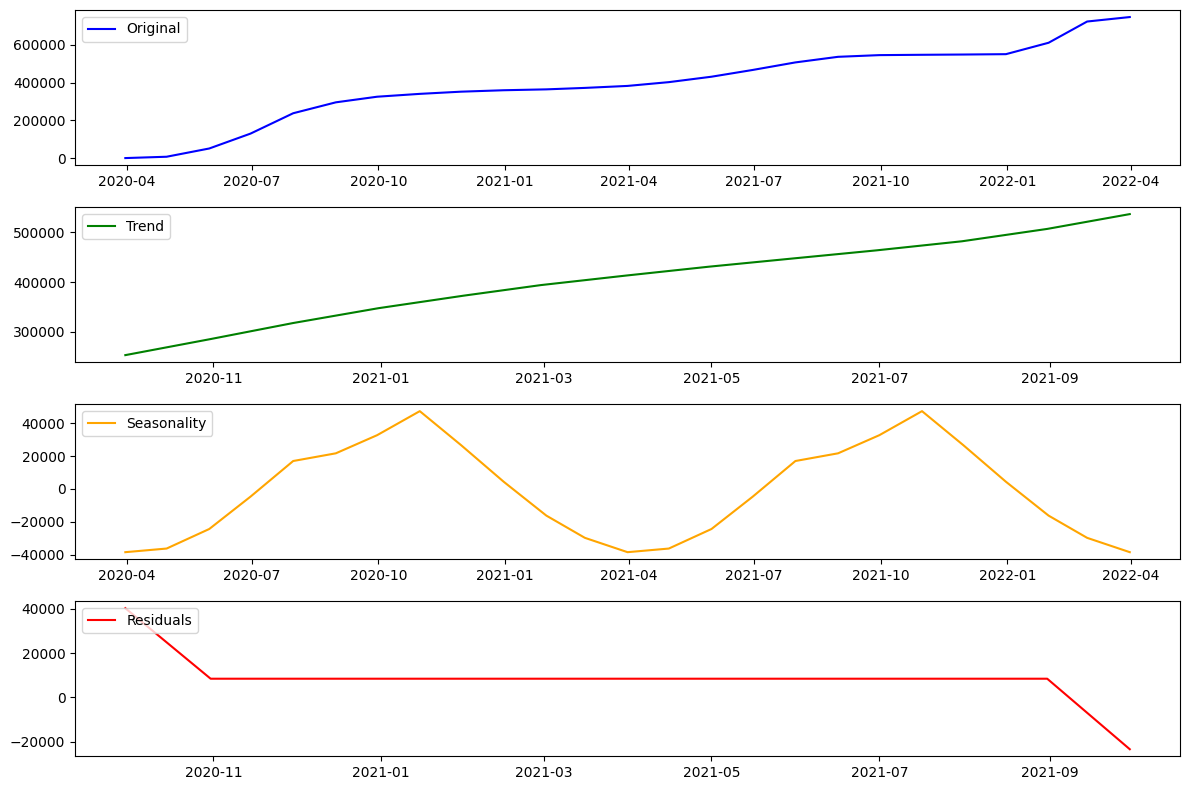

In [34]:
# sum of them equal the original column
result = seasonal_decompose(df_saudi_agg_month['cases_total'], model='additive')  # or model='multiplicative'

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_saudi_agg_month['cases_total'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='green')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

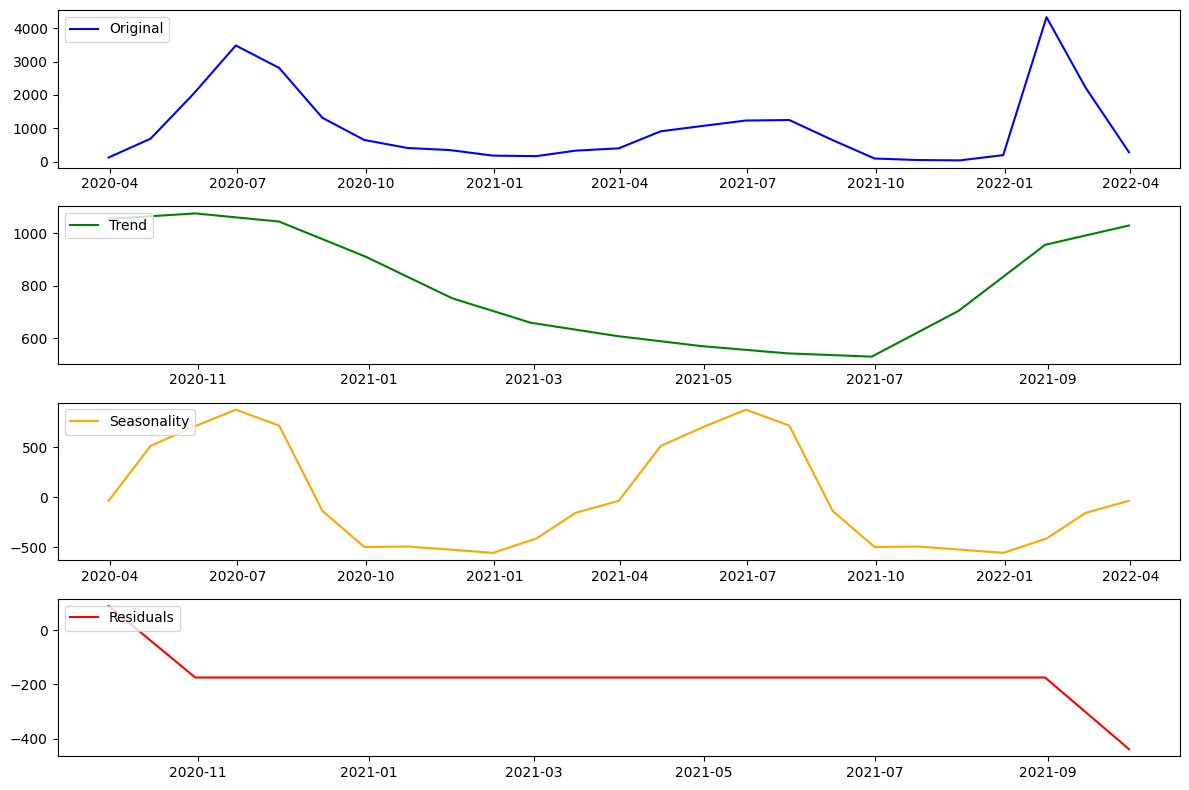

In [35]:
result = seasonal_decompose(df_saudi_agg_month['cases_new'], model='additive')  # or model='multiplicative'

# Plot the decomposed components
plt.figure(figsize=(12, 8))
plt.subplot(411)
plt.plot(df_saudi_agg_month['cases_new'], label='Original', color='blue')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='green')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal,label='Seasonality', color='orange')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residuals', color='red')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

#### 2. Feature selection

In [36]:
# Select the column
series = df_saudi_agg_day['cases_total']

#### 4. Prepare train and test data

In [37]:
split_point = int(len(series) * 0.8)
print(split_point)
train, test = series[:split_point], series[split_point:]

580


In [38]:
train.shape, test.shape

((580,), (146,))

## Bulid and train the Model

In [39]:
# Moving Average
window_size = 4
train_sma = train.rolling(window=window_size).mean()
train_sma.shape

(580,)

In [67]:
# Simple Exponential Smoothing
model = SimpleExpSmoothing(train)
fitted_model = model.fit(smoothing_level=0.2, optimized=False)

## Test the Model

In [ ]:
forecast = fitted_model.forecast(len(test))
# forecast

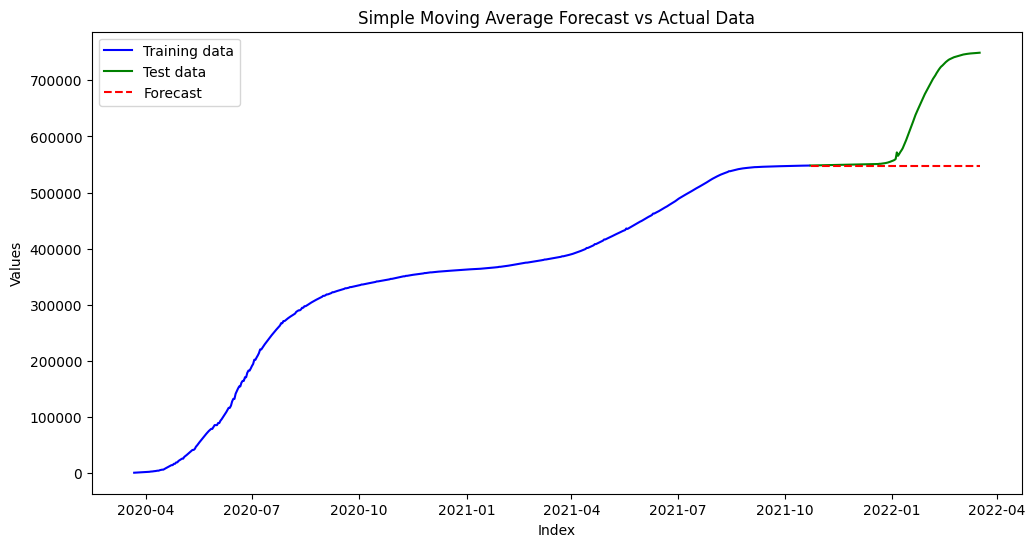

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Training data', color='blue')
plt.plot(test.index, test, label='Test data', color='green')
plt.plot(test.index, forecast, label='Forecast', color='red', linestyle='--')
plt.title('Simple Moving Average Forecast vs Actual Data')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()

## Evaluating the Model 

In [46]:
base_model = [train.mean()] * len(test)
mae = mean_absolute_error(test, base_model)
mae 

277562.46719414263

In [47]:
# Assuming 'forecast' and 'test' are your predicted and actual values respectively
mae = mean_absolute_error(test, forecast)

print(f"Mean Absolute Error (MAE): {mae:.2f}")

Mean Absolute Error (MAE): 71779.24
